### Report
- accuracy more than 60%
- LR schedule
- tensorboardx

In [18]:
import torch
import torchvision
import torchvision.transforms as transforms

batch_size = 4
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

print("len(train_dataset) =", len(train_dataset))

val_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
val_dataloader= torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("len(val_dataset) =", len(val_dataset))



Files already downloaded and verified
len(train_dataset) = 50000
Files already downloaded and verified
len(val_dataset) = 10000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape = torch.Size([4, 3, 32, 32])
labels = tensor([1, 2, 7, 1])
labels.shape = torch.Size([4])


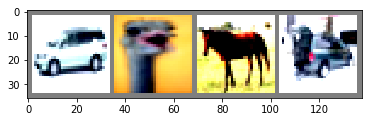

  car  bird horse   car


In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    img = img.cpu().numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()


# get some random training images
images, labels = next(iter(train_dataloader))

print("images.shape =", images.shape)

print("labels =", labels)
print("labels.shape =", labels.shape)

# show images
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


In [20]:
import torch.nn as nn
import torch.nn.functional as F


class SimpleConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=2)
        
        self.pool = nn.MaxPool2d(2)
        
        self.l1 = nn.Linear(16 * 8 * 8, 128)
        self.l2 = nn.Linear(128, 64)
        self.l3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        
        x = x.view(-1, 16 * 8 * 8)
        
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))  
        x = self.l3(x)
        
        return x


model = SimpleConvNet().to(device)


In [21]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss().to(device)
opt = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# learning_rate = 1e-4
# opt = optim.Adam(model.parameters(), lr=learning_rate)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, 'min')

In [22]:
import os
from tensorboardX import SummaryWriter
from datetime import datetime

experiment_title = "cnn"

experiment_name = "{}@{}".format(experiment_title, datetime.now().strftime("%d.%m.%Y-%H:%M:%S"))
writer = SummaryWriter(log_dir=os.path.join("./tb", experiment_name))

In [23]:
from tqdm import tqdm_notebook as tqdm

n_iters_total = 0

for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for batch in tqdm(train_dataloader):
        # get the inputs
        image_batch, label_batch = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        
        # zero the parameter gradients
        opt.zero_grad()

        # forward + backward + optimize
        outputs = model(image_batch)
        loss = criterion(outputs, label_batch)
        
        scheduler.step(loss)
        
        loss.backward()
        opt.step()
        
        running_loss += loss.item()
        
        # dump statistics
        writer.add_scalar("train/loss", loss.item(), global_step=n_iters_total)
        n_iters_total += 1
        
        
    print("[epoch {}] loss: {:.3}".format(epoch, running_loss / len(train_dataloader)))




[epoch 0] loss: 2.31



[epoch 1] loss: 2.31



[epoch 2] loss: 2.31



[epoch 3] loss: 2.31



[epoch 4] loss: 2.31


In [25]:
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for batch in tqdm(val_dataloader):
        image_batch, label_batch = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        
        outputs = model(image_batch)
        predicted = torch.argmax(outputs, dim=1)
        
        total += labels.size(0)
        correct += (predicted == label_batch).sum().item()

print("Accuracy of the network on the 10000 val images: {:.4}%".format(100 * correct / total))



Accuracy of the network on the 10000 val images: 9.98%


## Finetuning

In [45]:
device = torch.device("cuda")

In [46]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [47]:
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

print("len(train_dataset) =", len(train_dataset))

val_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
val_dataloader= torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("len(val_dataset) =", len(val_dataset))

Files already downloaded and verified
len(train_dataset) = 50000
Files already downloaded and verified
len(val_dataset) = 10000


In [64]:
model = torchvision.models.alexnet(pretrained=True).to(device)
# model = torchvision.models.vgg11(pretrained=True).to(device)
model = model.cuda()
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

In [65]:
## iterate over parameters and freeze them
for param in model.features.parameters():
    param.requires_grad = False

In [66]:
classifier = nn.Sequential(
    nn.Dropout(),
    nn.Linear(256 * 6 * 6, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 128),
)

In [67]:
model.classifier = classifier

In [68]:
criterion = nn.CrossEntropyLoss().to(device)
opt = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)

In [69]:
## you code here (you can just copy-paste from code above)
from tqdm import tqdm_notebook as tqdm

for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0
    for batch in tqdm(train_dataloader):
        # get the inputs
        image_batch, label_batch = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        
        # zero the parameter gradients
        opt.zero_grad()

        # forward + backward + optimize
        outputs = model(image_batch)
        loss = criterion(outputs, label_batch)
        
        loss.backward()
        opt.step()
        
        running_loss += loss.item()
        
        
    print("[epoch {}] loss: {:.3}".format(epoch, running_loss / len(train_dataloader)))

RuntimeError: Expected object of backend CPU but got backend CUDA for argument #4 'mat1'

In [ ]:
## you code here (you can just copy-paste from code above)
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for batch in tqdm(val_dataloader):
        image_batch, label_batch = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        
        outputs = model(image_batch)
        predicted = torch.argmax(outputs, dim=1)
        
        total += labels.size(0)
        correct += (predicted == label_batch).sum().item()

print("Accuracy of the network on the 10000 val images: {:.4}%".format(100 * correct / total))